# Import libraries

In [1]:
# Abba Barde
# bardeabba@gmail.com


import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Read data

In [3]:
train = pd.read_excel('Training_dataset.xlsx')
train = train.drop('Additional Condition', axis=1)
train.head()

,Message,Label
0,I want to activate my credit card,activate_card_0
1,I don't know how to activate my card,activate_card_0
2,I want to activate my card,activate_card_0
3,Why is your activation process not working ?,activate_card_0
4,My bank card is not active,activate_card_0


In [ ]:
train.Label.unique()

array(['card_stop_0', 'contactless_0', 'get_card_limit_0',
       'get_transaction_info_0', 'info_abroad_0',
       'info_card_expiration_0', 'info_card_number_0',
       'info_card_types_credit_0', 'info_charges_abroad_0',
       'info_CVC_CVV_0', 'lost_card_0', 'modify_limit_0',
       'new_card_reader_0', 'new_pin_0', 'order_card_0d_extra',
       'order_card_0', 'pin_by_sms_0', 'unblock_card_0',
       'use_abroad_0a_credit', 'use_abroad_0b_debit', 'use_abroad_0',
       'use_abroad_0e_europe', 'use_abroad_0f_non_europe'], dtype=object)

In [ ]:
train.shape

(889, 2)

In [4]:
valid = pd.read_csv('Validation dataset.csv',delimiter=';')
valid.head()

,Message,Label
0,I want to use my card in Japan,use_abroad_0f_non_europe
1,Activate card abroad,use_abroad_0
2,I want to use my card in Portugal,use_abroad_0e_europe
3,I want to use my debit card abroad,use_abroad_0b_debit
4,i want to use my credit card in France,use_abroad_0a_credit


In [ ]:
valid.shape

(439, 2)

In [ ]:
test = valid[:39]
valid = valid[39:]

In [ ]:
test.tail()

,Message,Label
34,How can I unlock my card for abroad?,use_abroad_0
35,Can I get an overview of all my cards?,cards_overview_0
36,Can you activate my card abroad?,use_abroad_0
37,I have lost my bank card,lost_card_0
38,how can I get a new card ?,order_card_0


In [ ]:
train.shape

(889, 2)

In [ ]:
test.head()

,Message,Label
0,I want to use my card in Japan,use_abroad_0f_non_europe
1,Activate card abroad,use_abroad_0
2,I want to use my card in Portugal,use_abroad_0e_europe
3,I want to use my debit card abroad,use_abroad_0b_debit
4,i want to use my credit card in France,use_abroad_0a_credit


## Plot total counts of intents

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


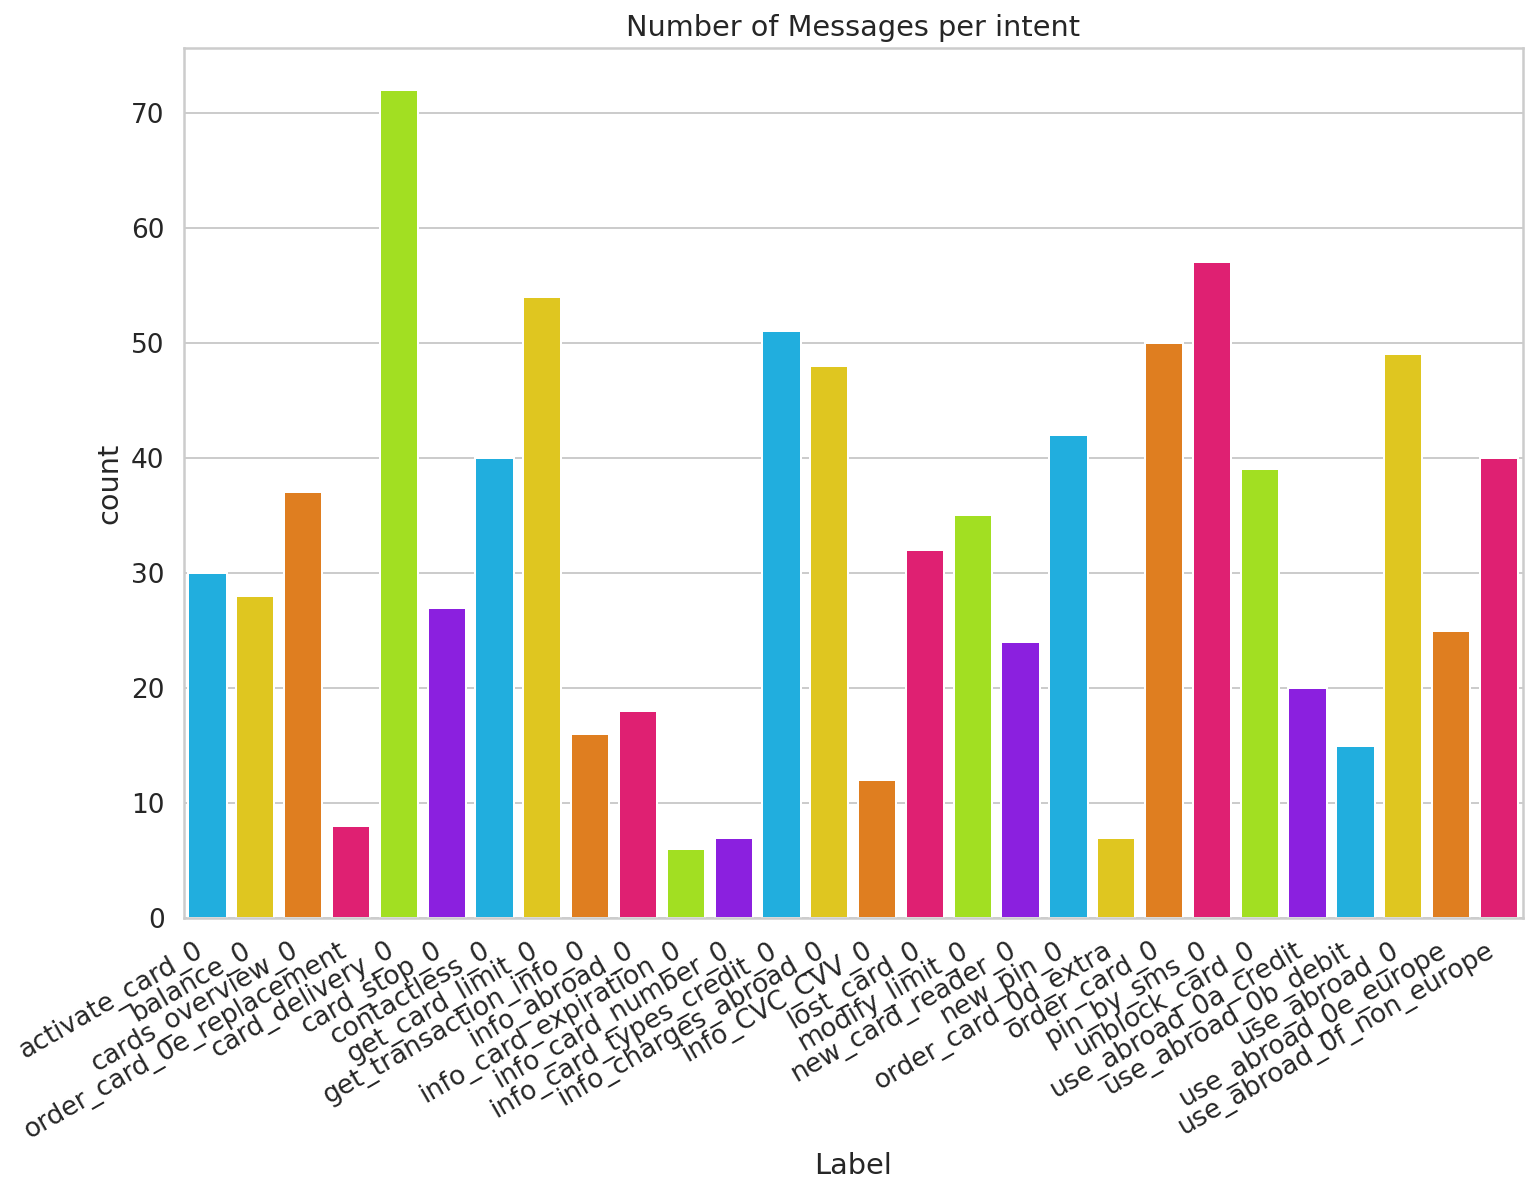

In [ ]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of Messages per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
!pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.8 MB 455 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tensorflow-gpu 2.10.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
tensorflow-gpu 2.10.0 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.0.2 which is incompatible.
tensorflow-gpu 2.10.0 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.0.1 which is incomp

In [ ]:
import pandas as pd
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"



In [ ]:
train = pd.read_excel('Training_dataset.xlsx')
train = train.drop('Additional Condition', axis=1)
train.head()

,Message,Label
0,I want to activate my credit card,activate_card_0
1,I don't know how to activate my card,activate_card_0
2,I want to activate my card,activate_card_0
3,Why is your activation process not working ?,activate_card_0
4,My bank card is not active,activate_card_0


In [7]:
test = pd.read_csv('Validation dataset.csv',delimiter=';')
test.head()

,Message,Label
0,I want to use my card in Japan,use_abroad_0f_non_europe
1,Activate card abroad,use_abroad_0
2,I want to use my card in Portugal,use_abroad_0e_europe
3,I want to use my debit card abroad,use_abroad_0b_debit
4,i want to use my credit card in France,use_abroad_0a_credit


In [ ]:
train.Label.value_counts()

card_delivery_0              72
pin_by_sms_0                 57
get_card_limit_0             54
info_card_types_credit_0     51
order_card_0                 50
use_abroad_0                 49
info_charges_abroad_0        48
new_pin_0                    42
use_abroad_0f_non_europe     40
contactless_0                40
unblock_card_0               39
cards_overview_0             37
modify_limit_0               35
lost_card_0                  32
activate_card_0              30
balance_0                    28
card_stop_0                  27
use_abroad_0e_europe         25
new_card_reader_0            24
use_abroad_0a_credit         20
info_abroad_0                18
get_transaction_info_0       16
use_abroad_0b_debit          15
info_CVC_CVV_0               12
order_card_0e_replacement     8
info_card_number_0            7
order_card_0d_extra           7
info_card_expiration_0        6
Name: Label, dtype: int64

In [ ]:
len(train.Label.unique())

28

In [ ]:
test.Label.value_counts()

use_abroad_0                 49
card_delivery_0              44
new_pin_0                    39
unblock_card_0               34
use_abroad_0f_non_europe     28
order_card_0                 28
modify_limit_0               27
activate_card_0              20
cards_overview_0             19
order_card_0e_replacement    17
info_charges_abroad_0        13
lost_card_0                  13
card_stop_0                  13
get_card_limit_0             12
use_abroad_0a_credit         10
balance_0                     9
contactless_0                 9
pin_by_sms_0                  8
new_card_reader_0             8
use_abroad_0b_debit           7
use_abroad_0e_europe          6
info_card_number_0            5
inactive_card_0               4
get_transaction_info_0        3
order_card_0d_extra           3
info_CVC_CVV_0                3
info_abroad_0                 3
info_card_expiration_0        3
info_card_types_credit_0      2
Name: Label, dtype: int64

In [ ]:
# train = train.drop('Label', axis=1)
# test = test.drop('Label', axis=1)

train.head()

,Message,Label
0,I want to activate my credit card,activate_card_0
1,I don't know how to activate my card,activate_card_0
2,I want to activate my card,activate_card_0
3,Why is your activation process not working ?,activate_card_0
4,My bank card is not active,activate_card_0


## Create train and test labels and features

In [17]:
trainfeatures=train.copy()
trainlabels=trainfeatures.pop("Label")
trainfeatures=trainfeatures.values

In [18]:
#trainfeatures = trainfeatures.values
trainfeatures = trainfeatures[30:]
trainlabels = trainlabels[30:]
testlabels = trainlabels[:30]
testfeatures = trainfeatures[:30]

validfeatures=test.copy()
validlabels=validfeatures.pop("Label")

# testfeatures=testfeatures.values
validfeatures=validfeatures.values

from sklearn.preprocessing import LabelBinarizer
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

## Check binarizer

In [20]:
len(binarizer.classes_)

27

In [21]:
import pickle

with open('labels.pkl', 'wb') as f:
    pickle.dump(binarizer, f)
    

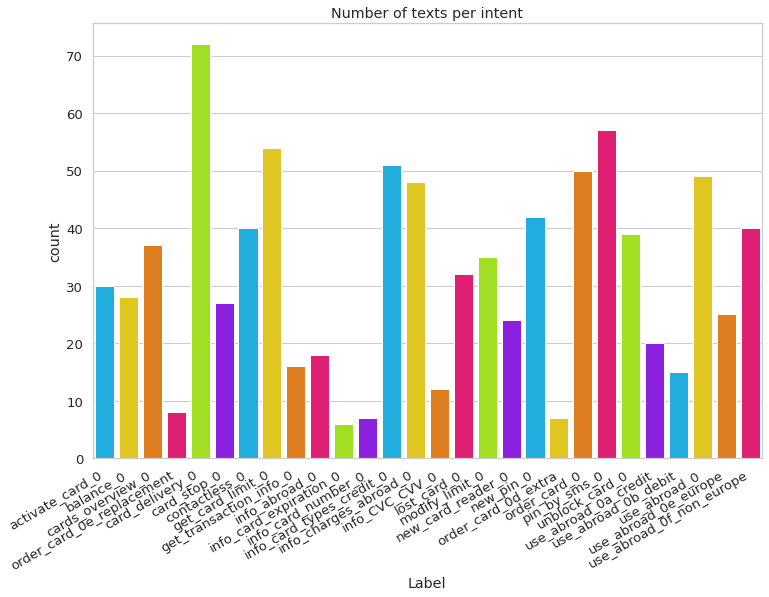

In [ ]:
import os
#import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

chart = sns.countplot(trainlabels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
testfeatures = trainfeatures[:30]

array([['I want to activate my credit card'],
       ["I don't know how to activate my card"],
       ['I want to activate my card'],
       ['Why is your activation process not working ?'],
       ['My bank card is not active'],
       ['I cannot activate my card'],
       ['How can I start using my card?'],
       ['I want to activate my debit card'],
       ['I need your help to activate my card'],
       ["Please activate my card for me, it's not working"],
       ['Do I have to do anything before I can use my card?'],
       ['How can I activate my card?'],
       ['I do not understand how to activate my card'],
       ['How can I get my card activated?'],
       ['I would like to activate another card'],
       [' my card cannot be activated via SMS'],
       ['activation'],
       ['How does the activation of my credit card work?'],
       ['I got an empty message as an answer to activate my card'],
       ['Is it possible to unlock my card?'],
       ['I got an error message wh

## Load models from TensorFlowHub

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


## Preprocessing Model

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
trainfeatures[0]

array(['Do I have a credit card or a debit card ?'], dtype=object)

In [ ]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2079  1045  2031  1037  4923  4003  2030  1037  2139 16313  4003]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## Loading and Using BERT

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.28042492 -0.40826198 -0.99983925 -0.16189365  0.4283413  -0.16572647
 -0.99955285  0.01470485  0.26432568  0.13000116 -0.94140464 -0.17487802]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.07784171  0.57948476  0.56991345 ... -0.49044964  0.10968351
   0.64597714]
 [-0.42157483  0.05151502  0.43455753 ... -0.4010394   0.75030375
  -0.9361068 ]
 [-0.17519706 -0.1683969   0.91407657 ... -0.32584128  0.12964268
   0.25242722]
 ...
 [-0.4468913   0.2694952  -1.0334399  ...  0.10919101  2.02829
   0.20035739]
 [ 0.635422   -0.15386264 -1.0762475  ... -0.43956995  0.78052884
   0.7775034 ]
 [-0.20570986  0.58482087 -0.54140717 ...  0.01582414  0.7931814
   0.15089051]]


## Defining model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(26, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.05624643 0.0549392  0.08296778 0.03854654 0.0124128  0.02824586
  0.01101223 0.0330848  0.02677992 0.01468668 0.01830185 0.05794263
  0.05355189 0.01767831 0.02583029 0.03460119 0.15224019 0.04713641
  0.0186871  0.02153106 0.01004421 0.00680227 0.01472211 0.02043002
  0.12968165 0.01189658]], shape=(1, 26), dtype=float32)


In [ ]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

## Loading the BERT model and training

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs=10
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - ETA: 0s - loss: 3.2937 - categorical_accuracy: 0.0905 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f36fbbef950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - 

## Evaluate the model

In [ ]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 [==============================] - 5s 5s/step - loss: 0.4472 - categorical_accuracy: 0.9333
Loss: 0.4472309350967407
Accuracy: 0.9333333373069763


Accuracy 0.933 and loss 0.44

## Plot the accuracy and loss over time

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


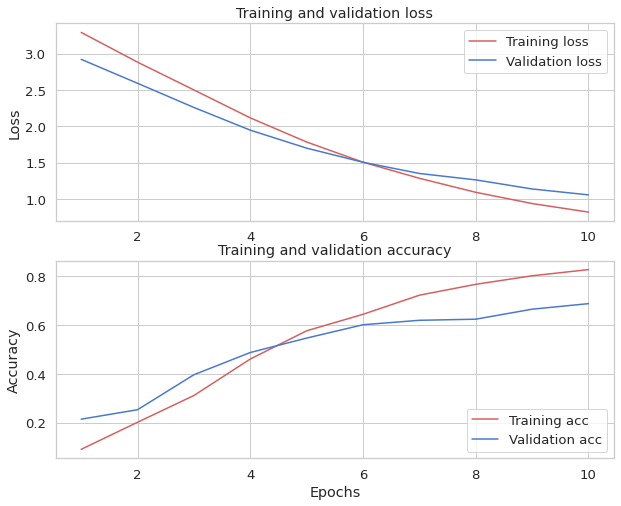

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Test model with messages

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : estimated intent: {results[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'my card is blocked',  # this is the same sentence tried earlier
    'How can my card be activated abroad',
    'Can i Get an update on the delivery status',
    'How much does it cost to withdraw money from ATM in the Amsterdam?',
    'I think my card is blocked'
]

results = tf.nn.softmax(classifier_model(tf.constant(examples)))

In [14]:
binarizer.classes_

array(['balance_0', 'card_delivery_0', 'card_stop_0', 'cards_overview_0',
       'contactless_0', 'get_card_limit_0', 'get_transaction_info_0',
       'info_CVC_CVV_0', 'info_abroad_0', 'info_card_expiration_0',
       'info_card_number_0', 'info_card_types_credit_0',
       'info_charges_abroad_0', 'lost_card_0', 'modify_limit_0',
       'new_card_reader_0', 'new_pin_0', 'order_card_0',
       'order_card_0d_extra', 'order_card_0e_replacement', 'pin_by_sms_0',
       'unblock_card_0', 'use_abroad_0', 'use_abroad_0a_credit',
       'use_abroad_0b_debit', 'use_abroad_0e_europe',
       'use_abroad_0f_non_europe'], dtype='<U25')

In [15]:
len(binarizer.classes_)

27

In [ ]:
import pickle

with open('labels.pkl', 'wb') as f:
    pickle.dump(lb, f)
    

In [ ]:
intents=binarizer.inverse_transform(results.numpy())

In [ ]:
print_my_examples(examples, intents)

input: my card is blocked             : estimated intent: unblock_card_0
input: How can my card be activated abroad : estimated intent: use_abroad_0
input: Can i Get an update on the delivery status : estimated intent: card_delivery_0
input: How much does it cost to withdraw money from ATM in the Amsterdam? : estimated intent: info_charges_abroad_0
input: I think my card is blocked     : estimated intent: unblock_card_0



In [ ]:
classifier_model.save('saved_model/my_model')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/assets/vocab.txt (deflated 53%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 81%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 31%)
  adding: saved_model/my_model/saved_model.pb (deflated 93%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 84%)


In [ ]:
classifier_model.save('my_model.h5')